# Container Detection using Template Matching

## 1. Setup and Configuration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from skimage.morphology import binary_closing, binary_opening, reconstruction
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image

In [2]:
# File paths
image_path = '../data/container.jpg'
training_gt = '../data/train_mask.tif'
evaluation_gt = '../data/eval_mask.tif'


# KNN parameters
n_neighbors = 5

# Morphological operations parameters
footprint_size = (3, 3)

# Structuring elements for corner detection (hit-or-miss transform)
corner_se_topleft = np.array([
    [1,  1, -1],
    [1,  1,  -1],
    [1,  1,  1]
], dtype=np.int8)

corner_se_topright = np.array([
    [1,  1, 1],
    [-1,  1, 1],
    [-1, 1, 1]
], dtype=np.int8)

corner_structuring_elements = [corner_se_topleft, corner_se_topright]

# Container color mapping for visualization
container_colors = {1: 'Red', 2: 'Blue', 3: 'White', 4: 'Green', 5: 'Background'}

# Custom colormap
custom_cmap = ListedColormap(['#808080', '#FF0000', '#0000FF', '#FFFFFF', '#008000'])

## 2. Data Loading and Preprocessing

In [3]:
# Load image and ground truth reference data
with rasterio.open(image_path) as src:
    rgb_image = src.read()

with rasterio.open(training_gt) as src:
    ground_truth_labels = src.read(1) 

bands, height, width = rgb_image.shape

pixel_features = rgb_image.reshape(bands, -1).T 
training_labels = ground_truth_labels.flatten()

/opt/anaconda3/envs/DataCentric/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
valid_pixels = (training_labels > 0)

training_features = pixel_features[valid_pixels]
training_labels_valid = training_labels[valid_pixels]

In [5]:
# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_classifier.fit(training_features, training_labels_valid)

KNeighborsClassifier()

## 3. Baseline Method - KNN Classification

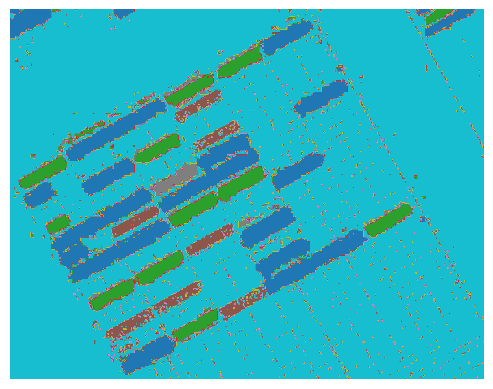

In [6]:
# Predict labels for all pixels in the image
predicted_labels = knn_classifier.predict(pixel_features)

# Reshape predictions back to original image dimensions
segmented_image = predicted_labels.reshape(height, width)

# Plot the classified image
plt.imshow(segmented_image, cmap="tab10") 
plt.axis("off")
plt.show()

In [7]:
container_mask = segmented_image
unique_container_labels = np.unique(container_mask)
unique_container_labels = unique_container_labels[unique_container_labels != 5]
unique_container_labels

array([1., 2., 3., 4.], dtype=float32)

## 4. Template Matching Implementation

### 4.1 Multilyaer Processing

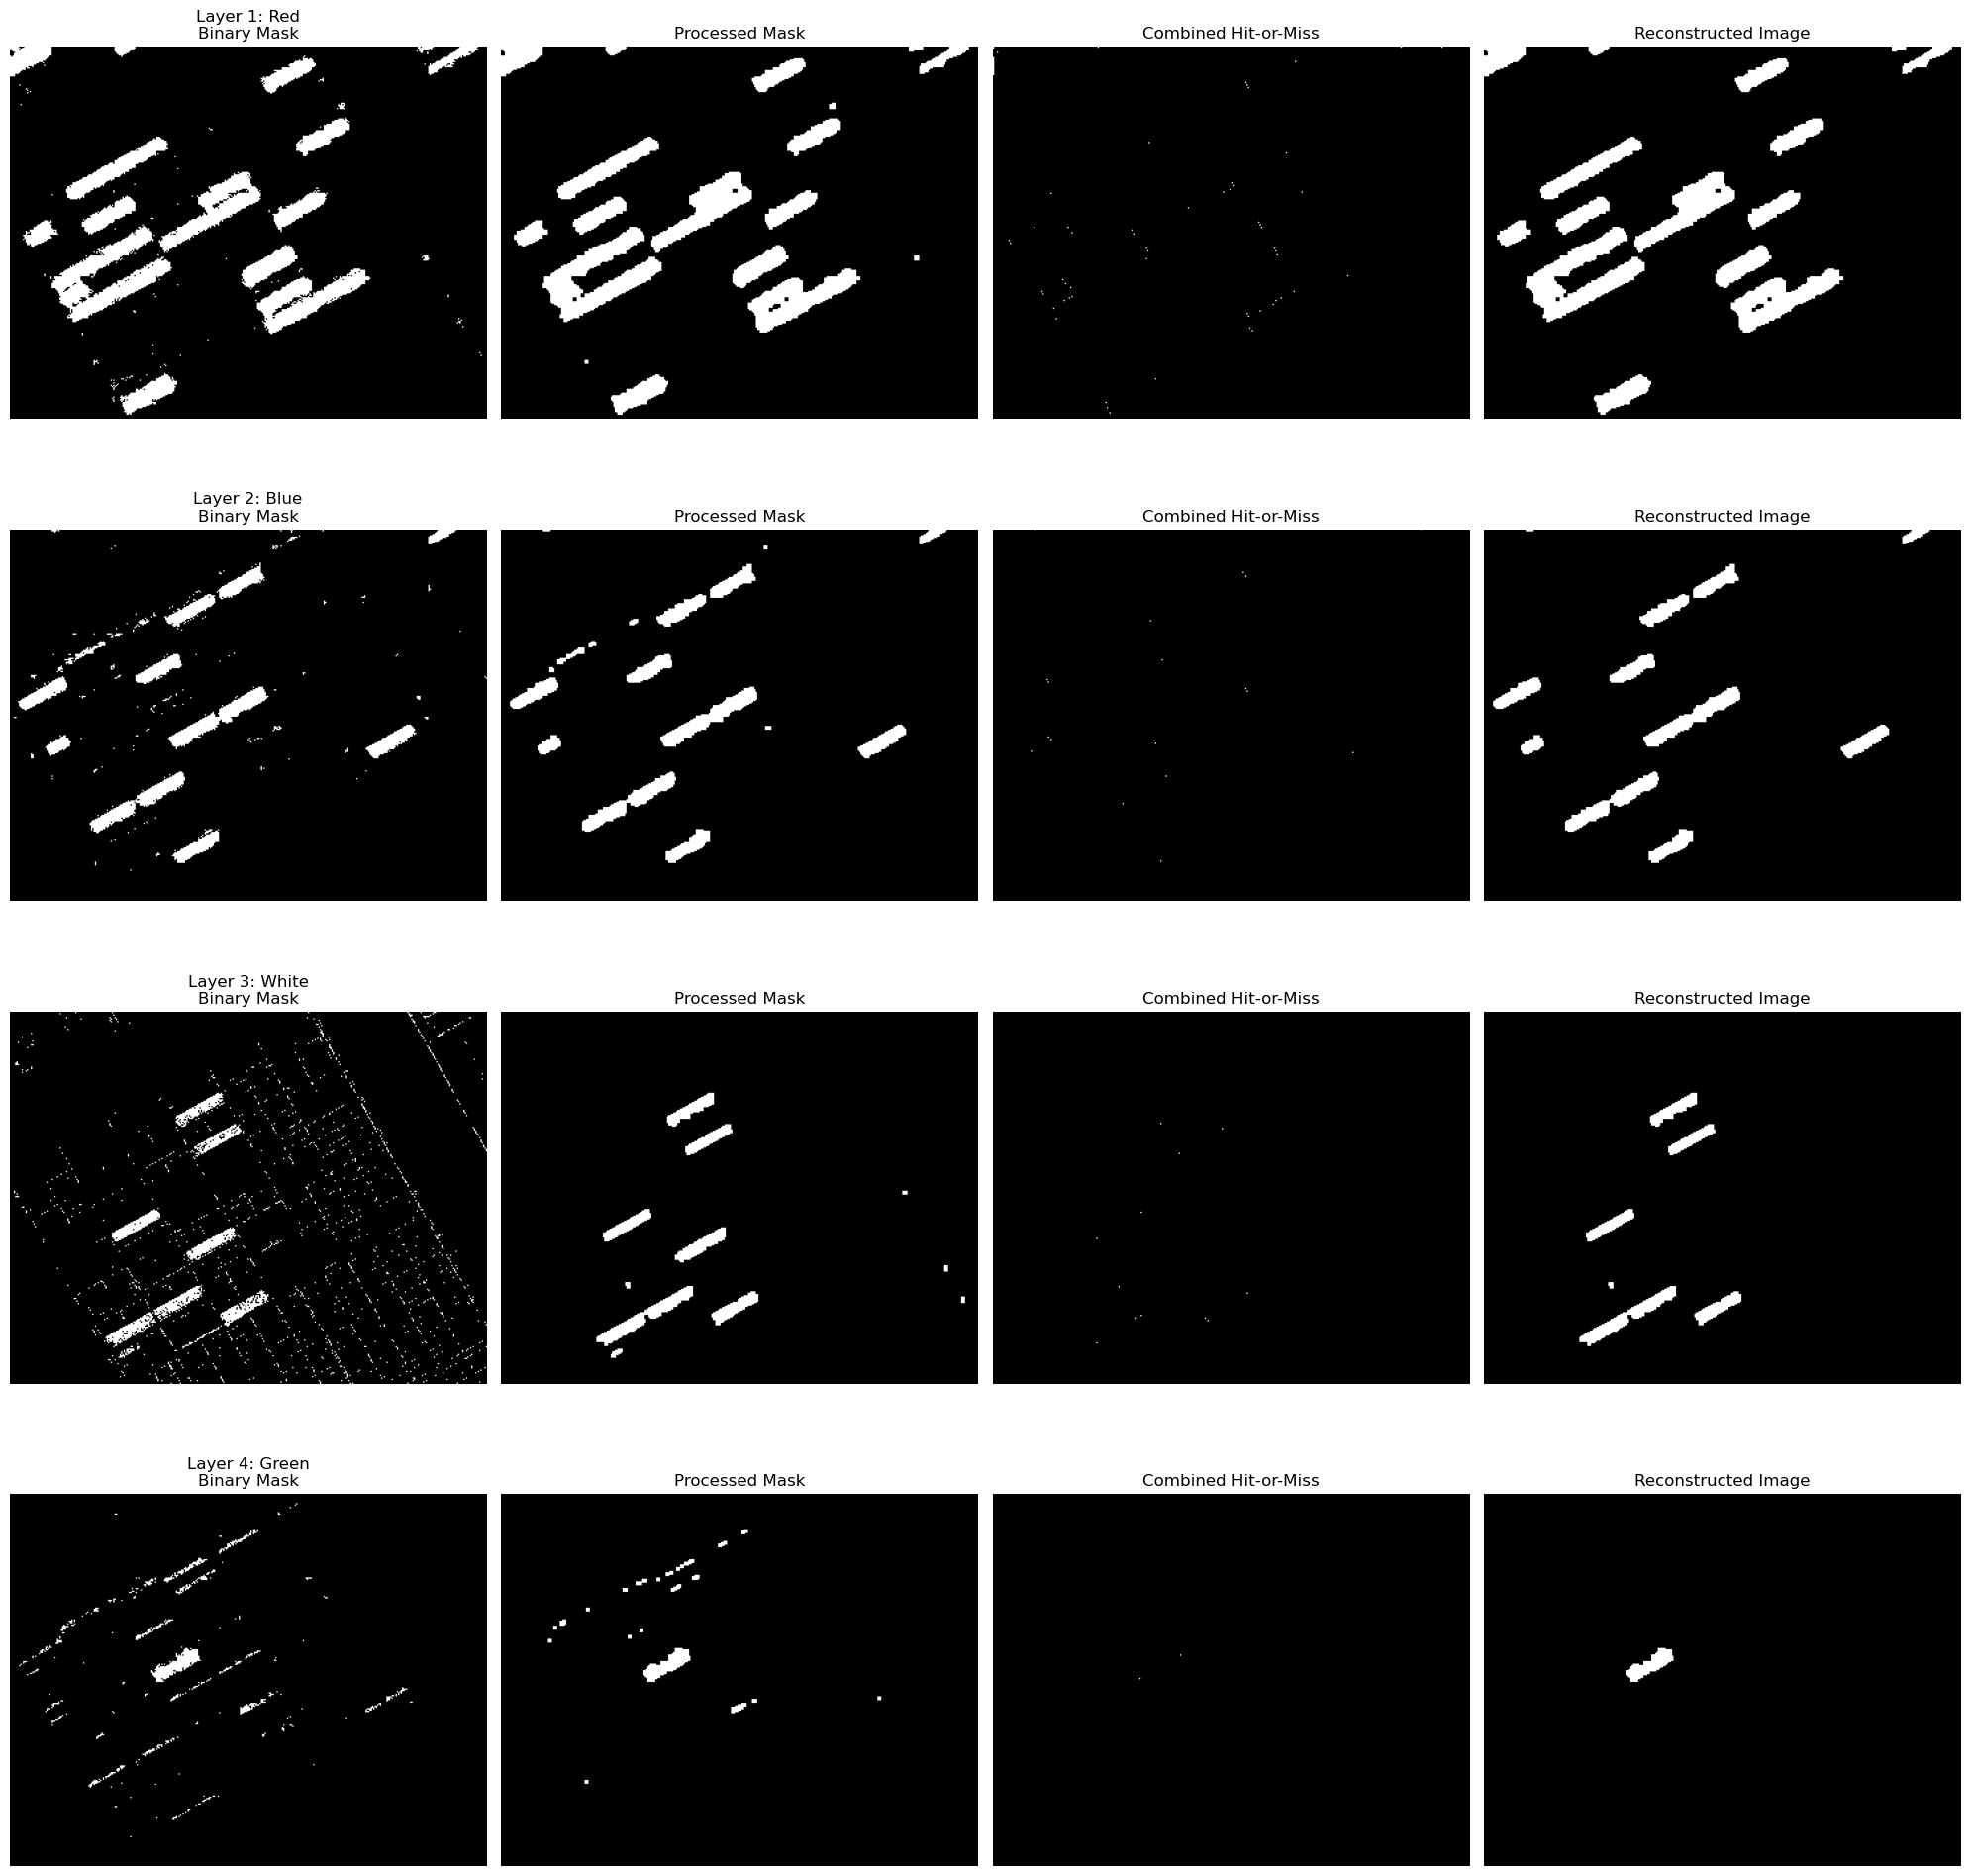

In [8]:
reconstructed_layers = {}

footprint = np.ones(footprint_size, dtype=np.uint8)

fig, axes = plt.subplots(len(unique_container_labels), 4, figsize=(20, 5 * len(unique_container_labels)))

for container_idx, container_label in enumerate(unique_container_labels):
    binary_mask = (container_mask == container_label).astype(np.uint8)
    
    processed_mask = binary_closing(binary_mask, footprint=footprint)
    processed_mask = binary_opening(processed_mask, footprint=footprint)
    processed_mask = (processed_mask > 0).astype(np.uint8) * 255

    combined_hit_or_miss = np.zeros_like(processed_mask, dtype=np.uint8)
    
    for structuring_element in corner_structuring_elements:
        foreground_kernel = (structuring_element == 1).astype(np.uint8)
        background_kernel = (structuring_element == -1).astype(np.uint8)
        eroded_foreground = cv2.erode(processed_mask, foreground_kernel)
        eroded_background = cv2.erode(255 - processed_mask, background_kernel)
        hit_miss_result = cv2.bitwise_and(eroded_foreground, eroded_background)
        hit_miss_result = (hit_miss_result > 0).astype(np.uint8)
        
        combined_hit_or_miss = cv2.bitwise_or(combined_hit_or_miss, hit_miss_result)
    
    reconstructed_image = reconstruction(combined_hit_or_miss, processed_mask // 255, method='dilation')
    reconstructed_image = (reconstructed_image > 0).astype(np.uint8)

    reconstructed_layers[container_label] = reconstructed_image
    
    layer_info = f"Layer {container_idx + 1}: {container_colors.get(container_label, 'Unknown')}"
    
    axes[container_idx, 0].imshow(binary_mask, cmap='gray')
    axes[container_idx, 0].set_title(f"{layer_info}\nBinary Mask")
    axes[container_idx, 0].axis('off')
    
    axes[container_idx, 1].imshow(processed_mask, cmap='gray')
    axes[container_idx, 1].set_title("Processed Mask")
    axes[container_idx, 1].axis('off')
    
    axes[container_idx, 2].imshow(combined_hit_or_miss, cmap='gray')
    axes[container_idx, 2].set_title("Combined Hit-or-Miss")
    axes[container_idx, 2].axis('off')
    
    axes[container_idx, 3].imshow(reconstructed_image, cmap='gray')
    axes[container_idx, 3].set_title("Reconstructed Image")
    axes[container_idx, 3].axis('off')

plt.tight_layout()
plt.show()


### 4.2 Layer Merging

In [9]:
template_shape = list(reconstructed_layers.values())[0].shape
final_mask = np.zeros(template_shape, dtype=np.uint8)

available_container_labels = [container_label for container_label in reconstructed_layers.keys() if container_label != 5]
container_priority_order = sorted(available_container_labels)

# Apply layers in priority order (higher priority overwrites lower priority)
for container_label in container_priority_order:
    if container_label in reconstructed_layers:
        container_layer = reconstructed_layers[container_label]
        final_mask[container_layer > 0] = container_label

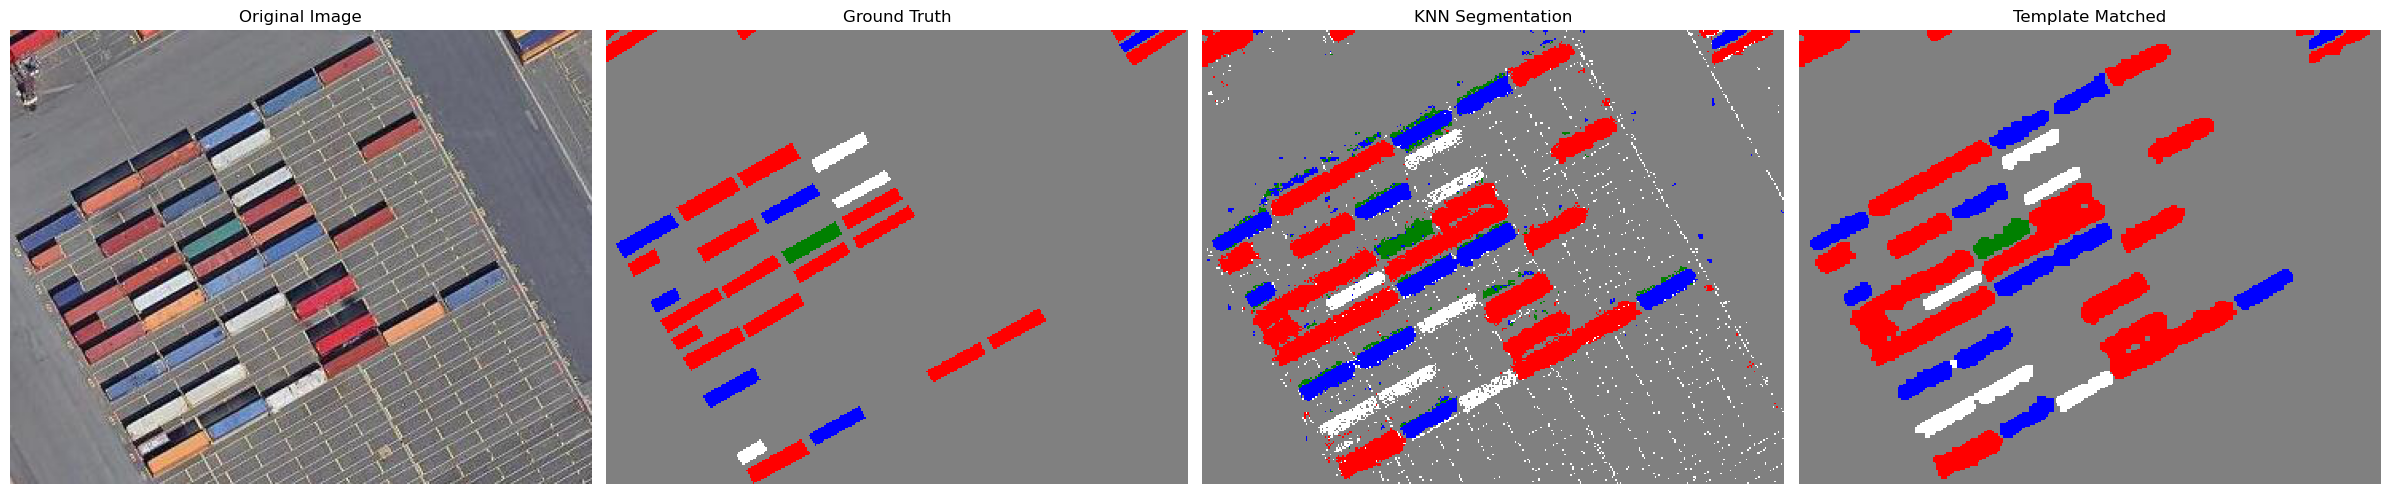

In [10]:
knn_output = segmented_image.copy()
knn_output[segmented_image == 5] = 0

# Load evaluation ground truth for comparison
eval_gt = np.array(Image.open(evaluation_gt))

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Original RGB image
axes[0].imshow(np.transpose(rgb_image, (1, 2, 0)))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Evaluation Ground Truth
axes[1].imshow(eval_gt, cmap=custom_cmap, interpolation="none")
axes[1].set_title("Ground Truth")
axes[1].axis('off')

# KNN Segmentation
axes[2].imshow(knn_output, cmap=custom_cmap, interpolation="none")
axes[2].set_title("KNN Segmentation")
axes[2].axis('off')

# Template Matched
axes[3].imshow(final_mask, cmap=custom_cmap, interpolation="none")
axes[3].set_title("Template Matched")
axes[3].axis('off')

plt.tight_layout()
plt.show()

## 5. Performance Evaluation

### 5.1 Evaluation Setup and Functions

In [11]:
# Load evaluation ground truth and prepare normalized data
eval_gt = np.array(Image.open(evaluation_gt))
knn_output = segmented_image.copy()
knn_output[segmented_image == 5] = 0

def calculate_class_iou(pred, gt, num_classes=5):
    """Calculate IoU for each class"""
    ious = []
    for class_id in range(num_classes):
        pred_mask = (pred == class_id)
        gt_mask = (gt == class_id)
        intersection = np.sum(pred_mask & gt_mask)
        union = np.sum(pred_mask | gt_mask)
        iou = intersection / union if union > 0 else (1.0 if intersection == 0 else 0.0)
        ious.append(iou)
    return ious

def calculate_weighted_metrics(pred, gt):
    """Calculate weighted precision, recall, and f1-score"""
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    
    precision = precision_score(gt_flat, pred_flat, average='weighted', zero_division=0) * 100
    recall = recall_score(gt_flat, pred_flat, average='weighted', zero_division=0) * 100
    f1 = f1_score(gt_flat, pred_flat, average='weighted', zero_division=0) * 100
    
    return precision, recall, f1

### 5.2 Multi-Class Performance Analysis

In [12]:
# Calculate IoUs and weighted metrics for both methods
knn_ious = calculate_class_iou(knn_output, eval_gt)
template_ious = calculate_class_iou(final_mask, eval_gt)

knn_w_precision, knn_w_recall, knn_w_f1 = calculate_weighted_metrics(knn_output, eval_gt)
template_w_precision, template_w_recall, template_w_f1 = calculate_weighted_metrics(final_mask, eval_gt)

### 5.3 Multi-Class Results Visualization

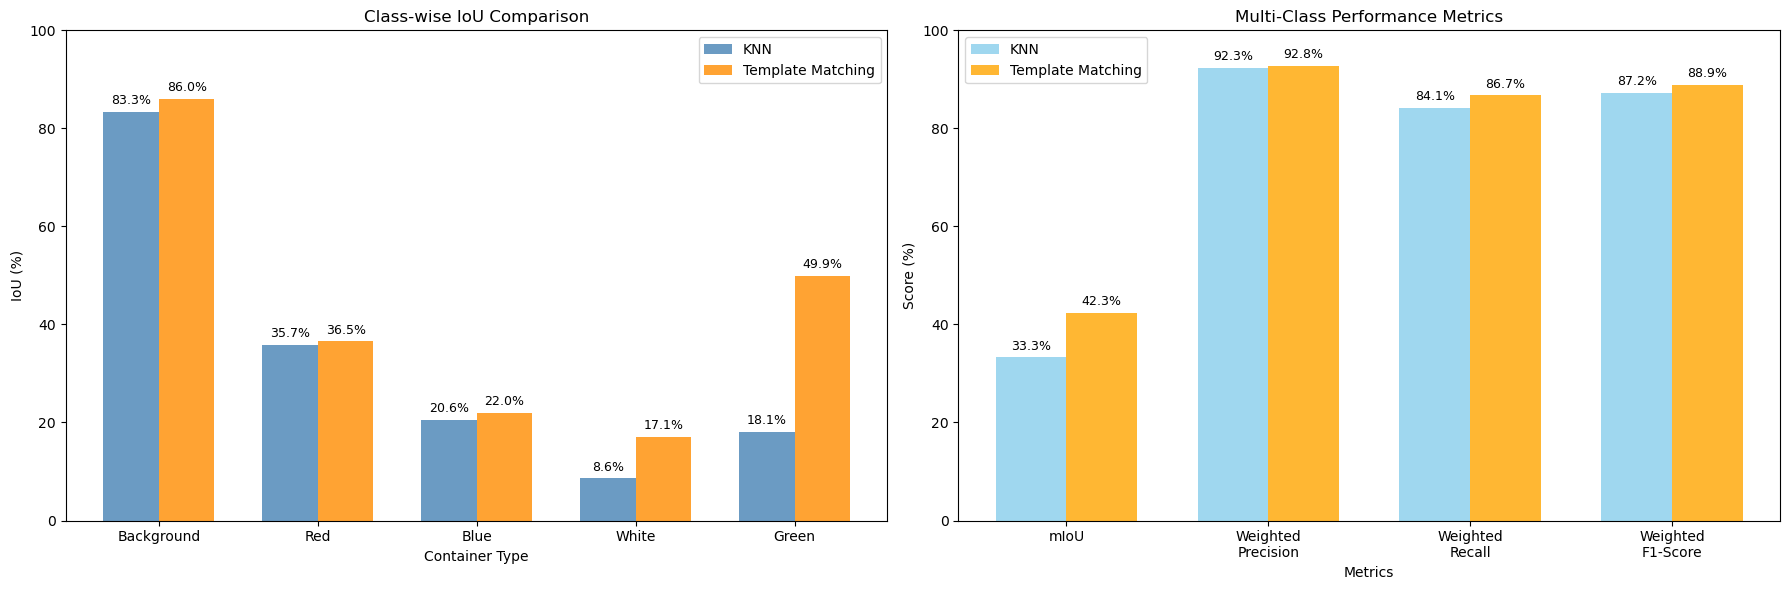

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

class_names = ['Background', 'Red', 'Blue', 'White', 'Green']
x = np.arange(len(class_names))
width = 0.35
knn_percent = [iou * 100 for iou in knn_ious]
template_percent = [iou * 100 for iou in template_ious]

ax1.bar(x - width/2, knn_percent, width, label='KNN', alpha=0.8, color='steelblue')
ax1.bar(x + width/2, template_percent, width, label='Template Matching', alpha=0.8, color='darkorange')

for i, (k_val, t_val) in enumerate(zip(knn_percent, template_percent)):
    ax1.text(i - width/2, k_val + 1, f'{k_val:.1f}%', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, t_val + 1, f'{t_val:.1f}%', ha='center', va='bottom', fontsize=9)

ax1.set_xlabel('Container Type')
ax1.set_ylabel('IoU (%)')
ax1.set_title('Class-wise IoU Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(class_names)
ax1.legend()
ax1.set_ylim(0, 100)

metrics = ['mIoU', 'Weighted\nPrecision', 'Weighted\nRecall', 'Weighted\nF1-Score']
knn_miou = np.mean(knn_ious) * 100
template_miou = np.mean(template_ious) * 100

knn_scores = [knn_miou, knn_w_precision, knn_w_recall, knn_w_f1]
template_scores = [template_miou, template_w_precision, template_w_recall, template_w_f1]

x2 = np.arange(len(metrics))
ax2.bar(x2 - width/2, knn_scores, width, label='KNN', alpha=0.8, color='skyblue')
ax2.bar(x2 + width/2, template_scores, width, label='Template Matching', alpha=0.8, color='orange')

for i, (k_val, t_val) in enumerate(zip(knn_scores, template_scores)):
    ax2.text(i - width/2, k_val + 1, f'{k_val:.1f}%', ha='center', va='bottom', fontsize=9)
    ax2.text(i + width/2, t_val + 1, f'{t_val:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score (%)')
ax2.set_title('Multi-Class Performance Metrics')
ax2.set_xticks(x2)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

### 5.4 Multi-Class Results Summary

In [14]:
container_knn_miou = np.mean(knn_ious[1:]) * 100
container_template_miou = np.mean(template_ious[1:]) * 100

print(f"MULTI-CLASS RESULTS:")
print(f"Overall mIoU (including background):   KNN {knn_miou:.1f}% → Template Matching {template_miou:.1f}% ({template_miou-knn_miou:+.1f}%)")
print(f"Container mIoU (excluding background): KNN {container_knn_miou:.1f}% → Template Matching {container_template_miou:.1f}% ({container_template_miou-container_knn_miou:+.1f}%)")
print(f"Weighted Precision:                    KNN {knn_w_precision:.1f}% → Template Matching {template_w_precision:.1f}% ({template_w_precision-knn_w_precision:+.1f}%)")
print(f"Weighted Recall:                       KNN {knn_w_recall:.1f}% → Template Matching {template_w_recall:.1f}% ({template_w_recall-knn_w_recall:+.1f}%)")
print(f"Weighted F1-Score:                     KNN {knn_w_f1:.1f}% → Template Matching {template_w_f1:.1f}% ({template_w_f1-knn_w_f1:+.1f}%)")

MULTI-CLASS RESULTS:
Overall mIoU (including background):   KNN 33.3% → Template Matching 42.3% (+9.1%)
Container mIoU (excluding background): KNN 20.7% → Template Matching 31.4% (+10.6%)
Weighted Precision:                    KNN 92.3% → Template Matching 92.8% (+0.4%)
Weighted Recall:                       KNN 84.1% → Template Matching 86.7% (+2.6%)
Weighted F1-Score:                     KNN 87.2% → Template Matching 88.9% (+1.7%)


### 5.5 Binary Classification Analysis

In [15]:
def calculate_binary_metrics(pred_mask, gt_mask):
    """Calculate binary classification metrics: accuracy, precision, recall, f1, iou"""
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    
    accuracy = accuracy_score(gt_flat, pred_flat) * 100
    precision = precision_score(gt_flat, pred_flat, zero_division=0) * 100
    recall = recall_score(gt_flat, pred_flat, zero_division=0) * 100
    f1 = f1_score(gt_flat, pred_flat, zero_division=0) * 100
    
    intersection = np.sum((gt_flat == 1) & (pred_flat == 1))
    union = np.sum((gt_flat == 1) | (pred_flat == 1))
    iou = (intersection / union * 100) if union > 0 else 0
    
    return accuracy, precision, recall, f1, iou

def to_binary(mask):
    return np.isin(mask, [1, 2, 3, 4]).astype(np.uint8)

### 5.6 Binary Classification Results

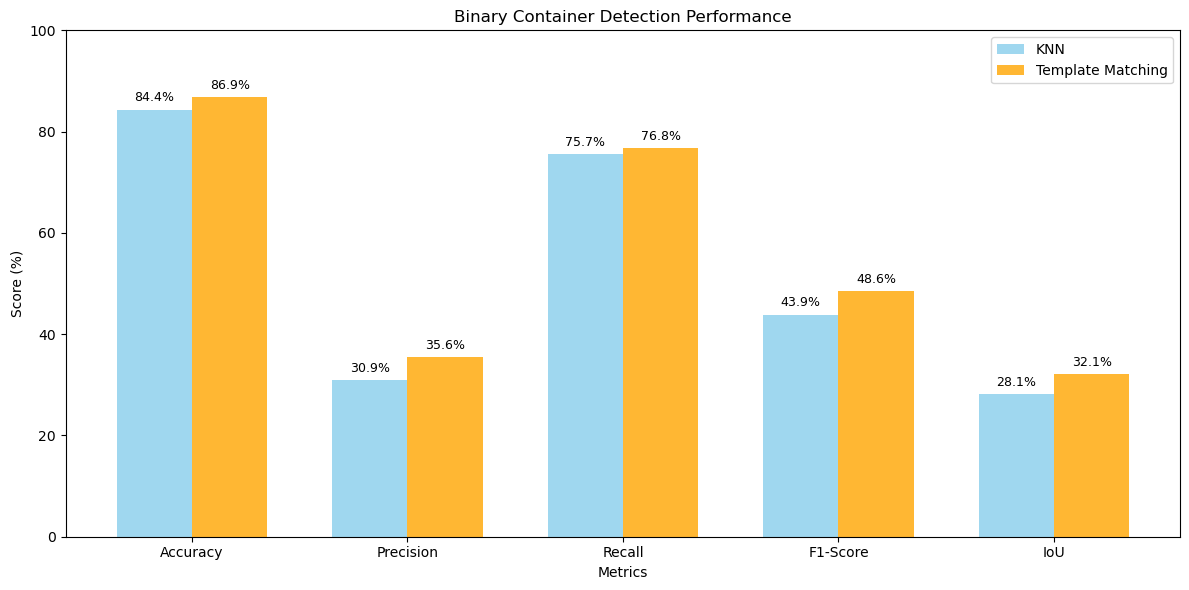

In [16]:
# Create binary masks and calculate metrics
eval_gt_binary = to_binary(eval_gt)
knn_binary = to_binary(segmented_image)
template_binary = to_binary(final_mask)

knn_metrics = calculate_binary_metrics(knn_binary, eval_gt_binary)
template_metrics = calculate_binary_metrics(template_binary, eval_gt_binary)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU']
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, knn_metrics, width, label='KNN', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, template_metrics, width, label='Template Matching', alpha=0.8, color='orange')

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 1, f'{knn_metrics[i]:.1f}%', ha='center', va='bottom', fontsize=9)
    ax.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 1, f'{template_metrics[i]:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score (%)')
ax.set_title('Binary Container Detection Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()